In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime as dt
from matplotlib import ticker

In [9]:
figure_path = 'figures_join_exit/'
os.makedirs(figure_path, exist_ok=True)

In [10]:
def plot_metrics_by_node(df, field_name, figure_path, start_time_limit_seconds=0, stop_time_before_end_seconds=90):
    filtered_df = df[df['field'] == field_name].copy()
    if filtered_df.empty:
        print(f"No data found for field: {field_name}")
        return

    if 'node' not in filtered_df.columns:
        print(f"'node' column not found in data for field: {field_name}")
        return

    filtered_df['node'] = filtered_df['node'].str.split('_').str[-1].astype(int)

    filtered_df['relative_time'] = (filtered_df['timestamp'] - filtered_df['timestamp'].min()).dt.total_seconds()

    max_time = filtered_df['relative_time'].max()
    filtered_df = filtered_df[
        (filtered_df['relative_time'] >= start_time_limit_seconds) &
        (filtered_df['relative_time'] <= max_time - stop_time_before_end_seconds)
    ]

    pivot_df = filtered_df.pivot(index='timestamp', columns='node', values='value')
    pivot_df = pivot_df.sort_index()
    pivot_df = pivot_df.ffill()
    pivot_df = pivot_df.bfill()

    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
    plt.rc('axes', axisbelow=True)
    plt.rcParams.update(
        {
            'font.size': 10,
            'xtick.labelsize': 8,
            'ytick.labelsize': 8
        }
    )

    plt.figure(figsize=(12, 7))
    for node in pivot_df.columns:
        plt.plot(
            pivot_df.index,
            pivot_df[node],
            label=f"Node {node}",
            linewidth=1.5,
            linestyle='-'
        )

    plt.title(f"{field_name.replace('_', ' ').title()}", fontsize=14)
    plt.xlabel("Timestamp", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend(title="Nodes", fontsize=10, loc="best")
    plt.grid(visible=True, linestyle='--', alpha=0.6)

    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: pd.to_datetime(x).strftime('%Y-%m-%d %H:%M')))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


In [11]:
def read_file(path):
    return pd.read_csv(path, comment='#')

In [12]:
def process_data(df):
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    if 'value' in df.columns:
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
    return df

In [13]:
def main(file_path, metric_names):
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")
        return

    data = read_file(file_path)
    data = process_data(data)

    unique_fields = data['field'].unique()

    for metric in metric_names:
        if metric in unique_fields:
            plot_metrics_by_node(data, metric, figure_path)
        else:
            print(f"Metric not found in data: {metric}")

Metric not found in data: total_messages_sent


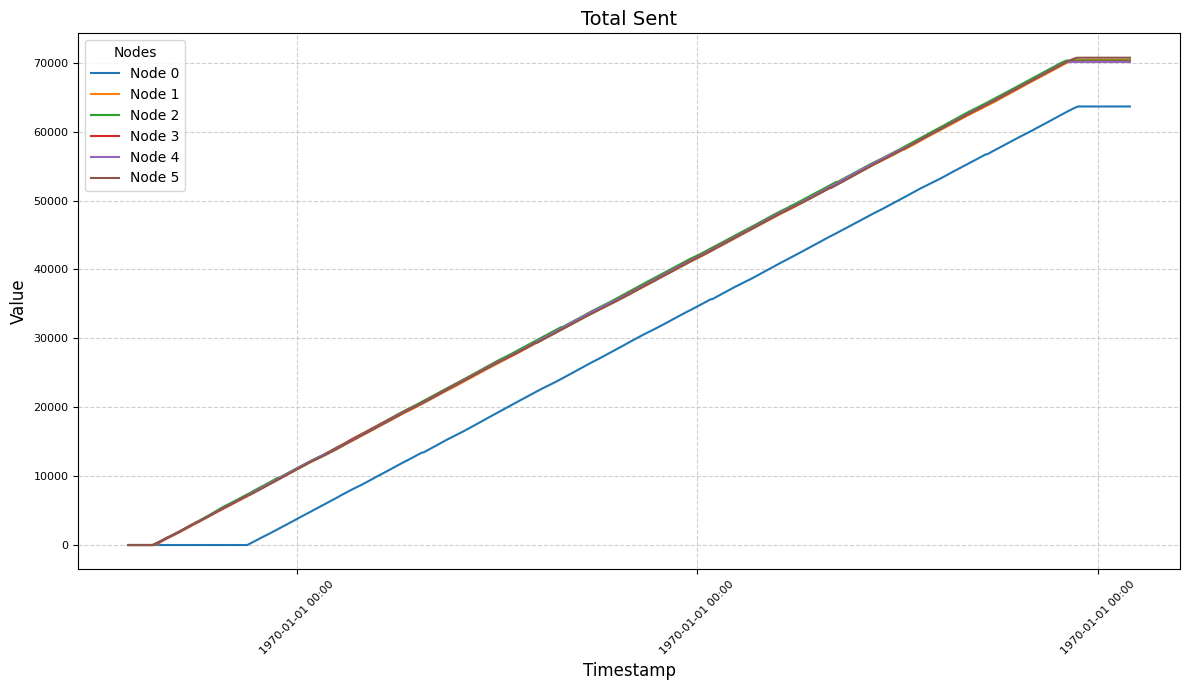

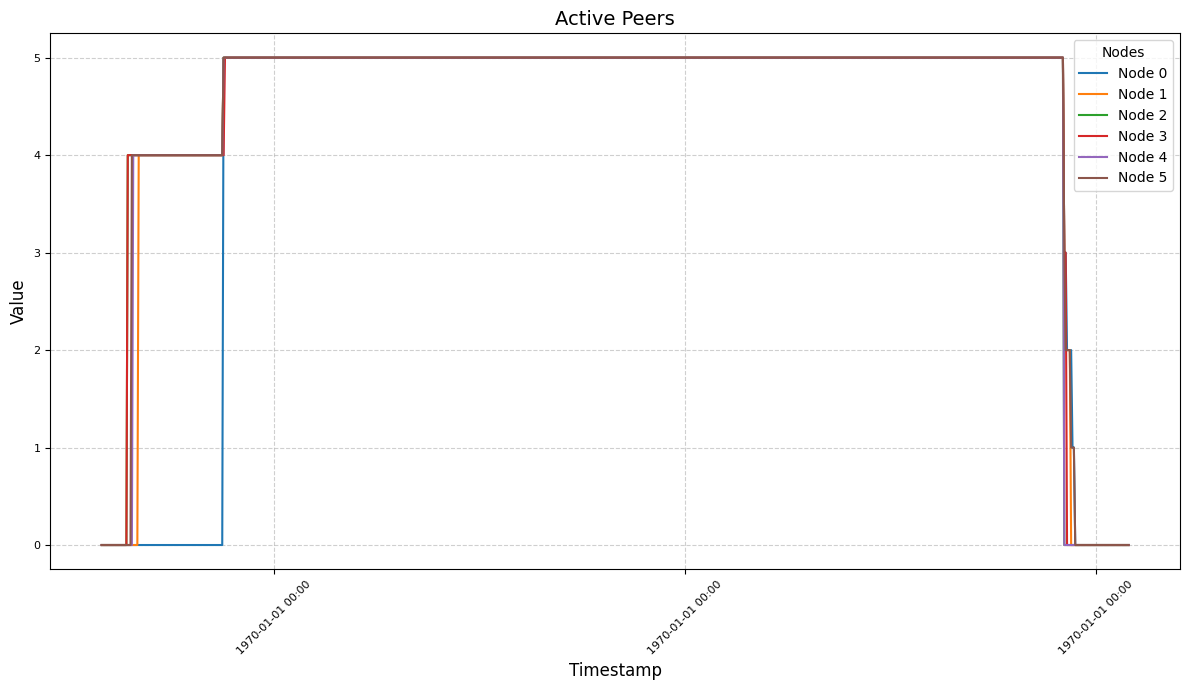

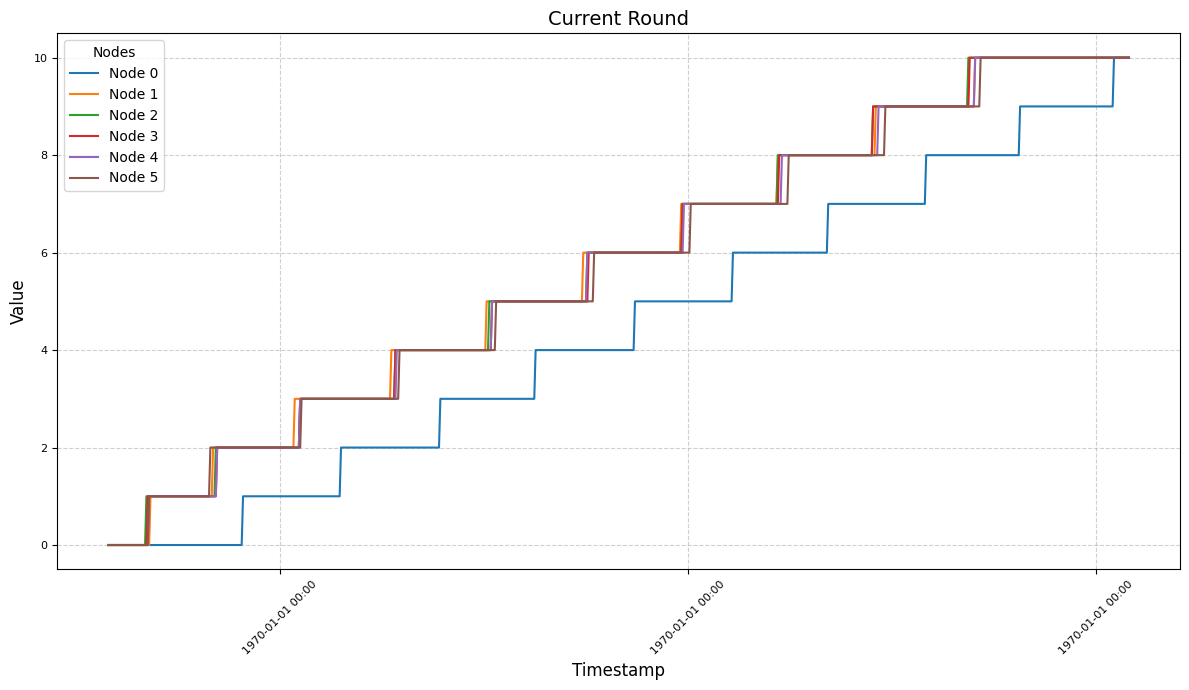

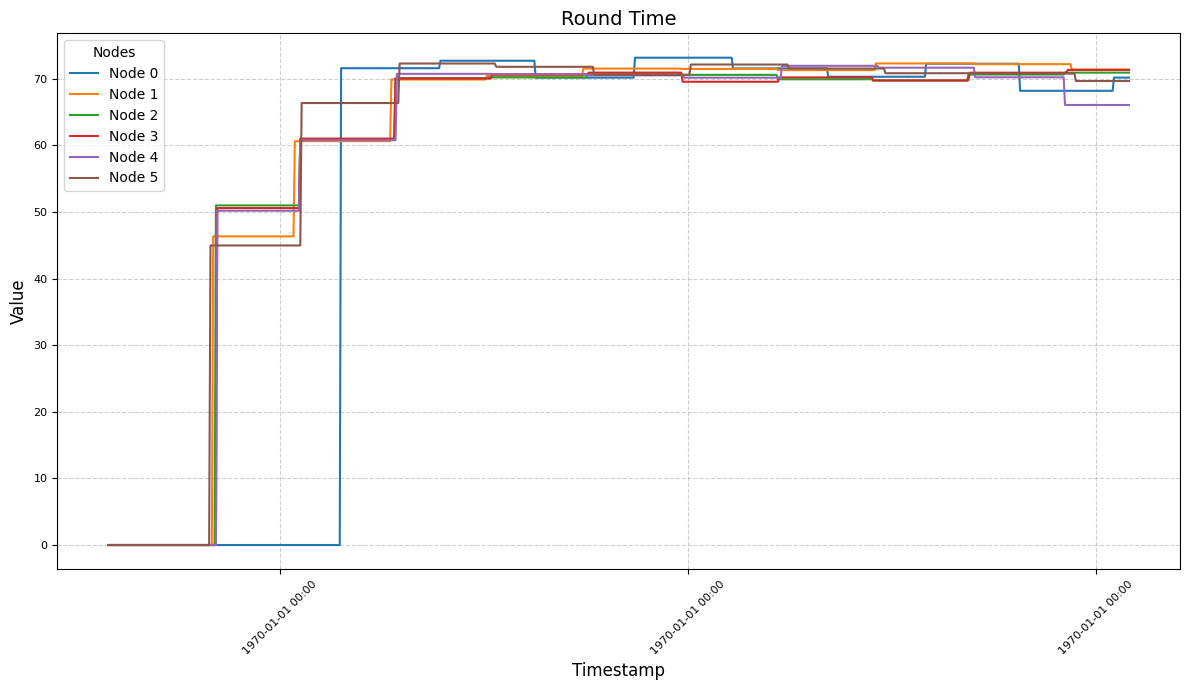

In [14]:
metrics_path = '../metrics/'
file_path = os.path.join(metrics_path, "join_node.csv")
metric_names = [
    'total_messages_sent',
    'total_sent',
    "active_peers",
    "current_round",
    "round_time",
]
main(file_path, metric_names)
